2025-07-25 10:13:41 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-25 10:13:41 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_2290906/3830137084.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Processing: pr_mean_annual_rmse


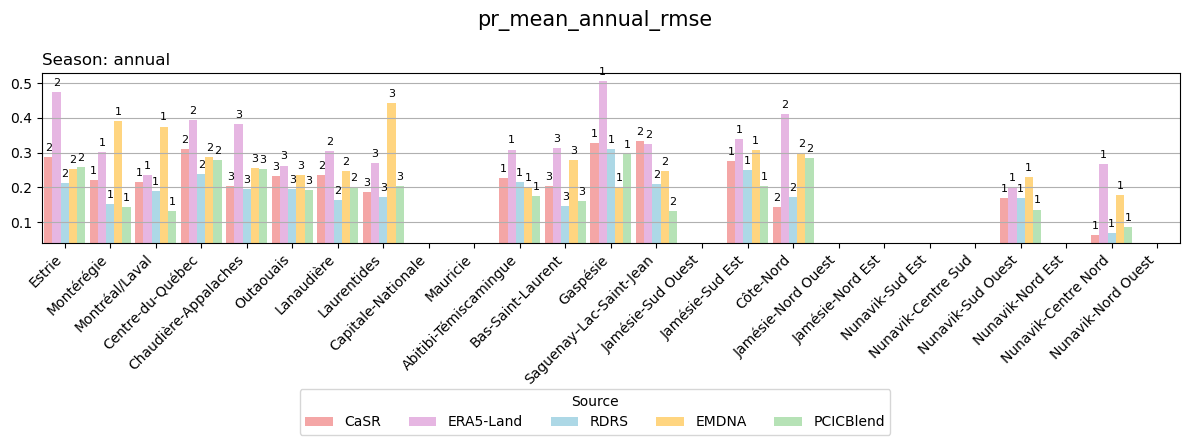

Processing: pr_mean_seasonal_rmse


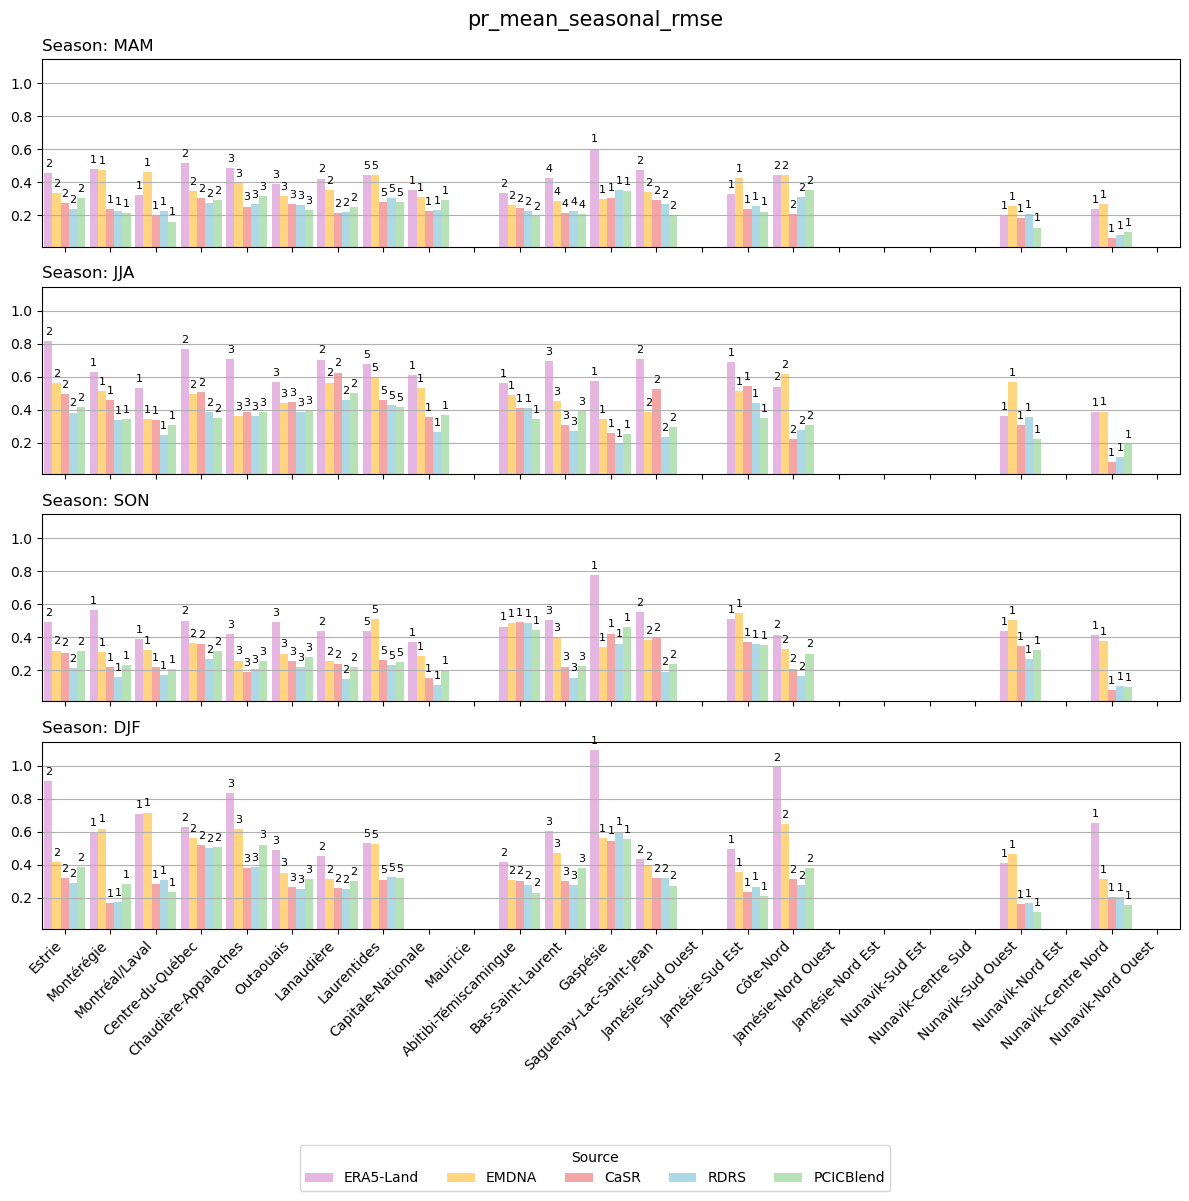

Processing: tg_mean_annual_rmse


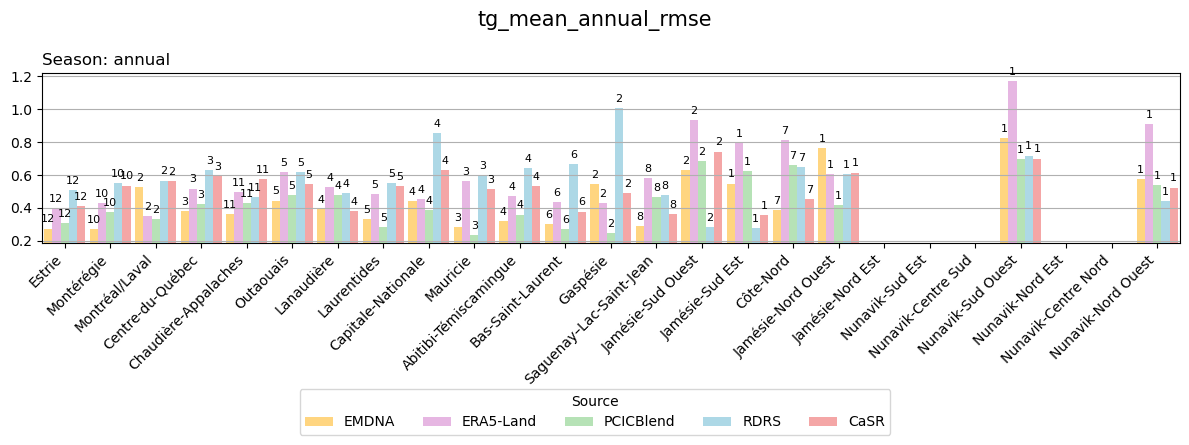

Processing: tg_mean_seasonal_rmse


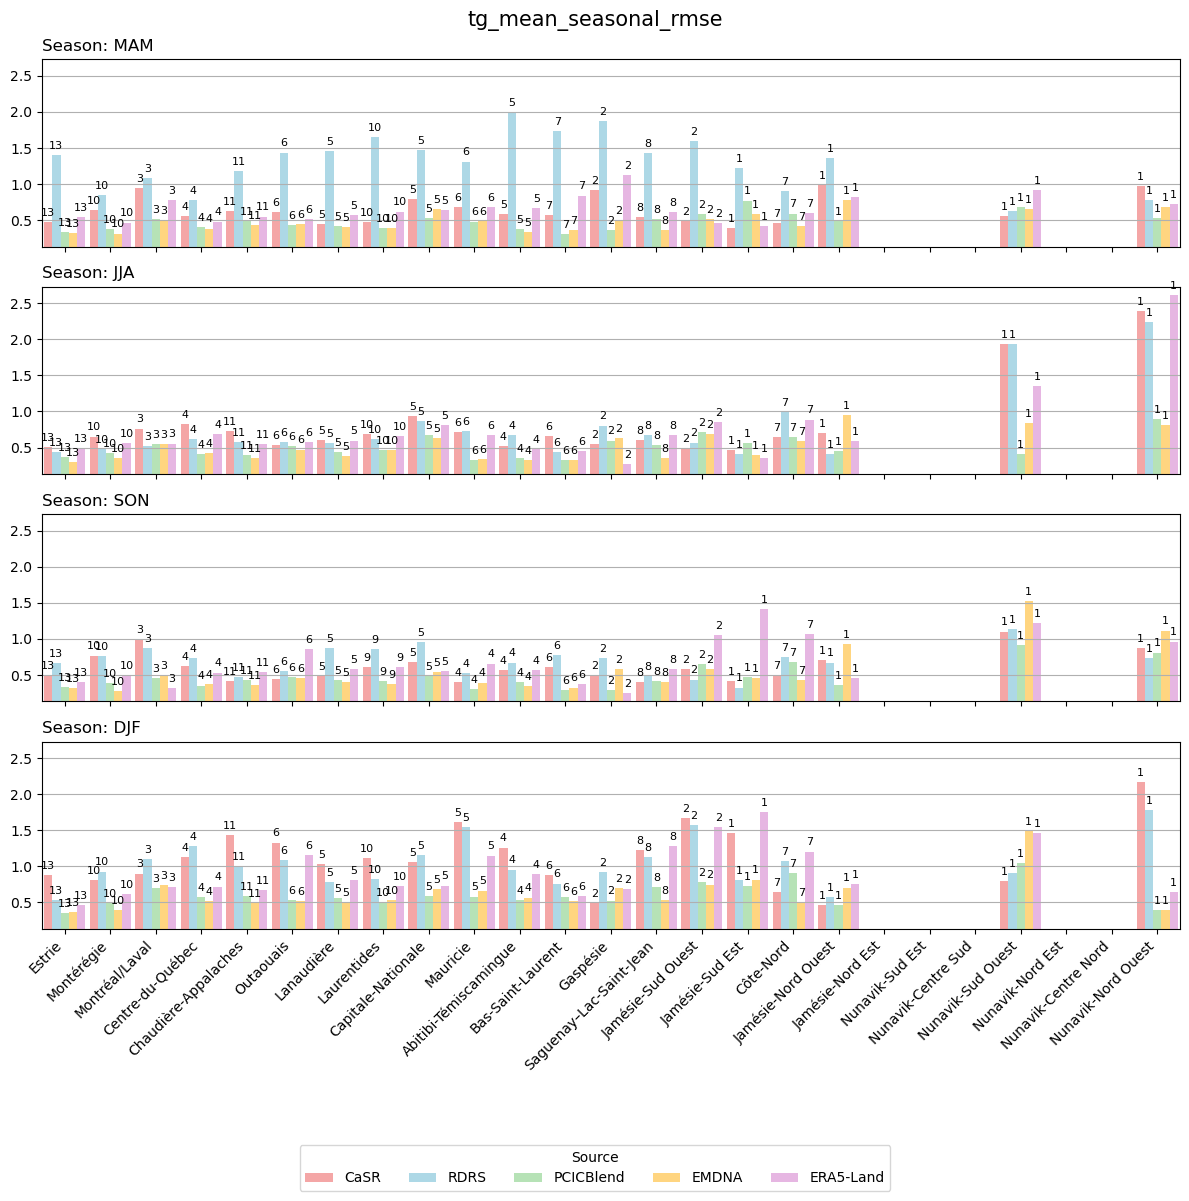

In [9]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd

# =========================
# Setup
# =========================
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Define source colors (unchanged)
SOURCE_COLORS = {
    "EMDNA": "#FFD580",
    "PCICBlend": "#B6E2B6",
    "RDRS": "#ADD8E6",
    "ERA5-Land": "#E6B6E2",
    "CaSR": "#F4A6A6"
}

# Load shapefile and compute centroids
gdf = gpd.read_file("../" + CONFIG["spatial_mean"]["region"]["shape"])
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# Choose sort direction (East-West or North-South)
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()  # or use "centroid_x"

# Get list of spatial_mean variables
df = pcat.df
df = df[df["processing_level"] == "spatial_mean"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# =========================
# Loop over variables
# =========================
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="spatial_mean", variable=var).to_dataset().compute()
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    # === Plot setup: Seasons as rows ===
    seasons = ds_all["season"].values
    n_rows = len(seasons)
    fig_height = 2.75 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=1,
        figsize=(12, fig_height),
        sharex=True
    )

    if n_rows == 1:
        axes = [axes]

    regions = REGION_ORDER
    sources = ds_all["source"].values

    # Compute consistent y-limits across all subplots
    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0

    bar_width = 0.9 / len(sources)  # distribute bars per group

    for i, season in enumerate(seasons):
        ax = axes[i]
        ds = ds_all.sel(season=season)
        da = ds[var]  # shape: (source, region)
        nstation_season = ds["nstation"].reindex(region=regions).values  # shape: (region,)

        x = np.arange(len(regions))
        for j, source in enumerate(sources):
            y = da.sel(source=source).reindex(region=regions).values
            color = SOURCE_COLORS.get(source, None)

            # Bar positions shifted by source
            bar_pos = x + j * bar_width - (len(sources) - 1) * bar_width / 2
            bars = ax.bar(bar_pos, y, width=bar_width, color=color, label=source, alpha=1)

            # Annotate station count on top of each bar
            for k, b in enumerate(bars):
                nst = nstation_season[k]
                if np.isfinite(nst):
                    ax.annotate(
                        f"{int(nst)}",
                        xy=(b.get_x() + b.get_width() / 2, b.get_height()),
                        xytext=(0, 3),  # offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8
                    )

        ax.set_title(f"Season: {season}", loc='left')
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True, axis='y')

    # Bottom x-axis labels
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(regions, rotation=45, ha='right')
    axes[-1].set_xlim(-0.5, len(regions) - 0.5)

    # Shared legend at bottom
    handles, labels = axes[0].get_legend_handles_labels()
    # Remove duplicates just in case
    uniq = dict(zip(labels, handles))
    fig.legend(uniq.values(), uniq.keys(), title="Source", loc='lower center',
               ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

    # Title and layout
    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.18, top=0.9)  # give a bit more space for the legend
    plt.tight_layout()
    plt.show()